In [143]:
from langchain.prompts import ChatPromptTemplate
import os
from dotenv import load_dotenv
from typing import TypedDict, Literal, Annotated
from langgraph.graph import StateGraph, START, END
import operator
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI

In [144]:
generator_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
evaluator_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
optimizer_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [145]:
# state
class PostState(TypedDict):

    topic: str
    post: str
    post_history: Annotated[list[str], operator.add]
    evaluation: Literal["approved", "needs_improvement"]
    message: str
    iteration: int
    max_iteration: int

In [146]:
def generate_post(state: PostState) -> PostState:
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a LinkedIn content creator."),
        ("user", "Write a LinkedIn post about: {topic}")
    ])
    response = (prompt | generator_llm).invoke({"topic": state["topic"]})
    
    return {
        "post": response.content,
        "iteration": 0,
        "post_history": [response.content]
    }


In [147]:
def evaluate_post(state: PostState) -> PostState:
    post = state.get("post", "")
    if state["iteration"] >= state["max_iteration"]:
        return {
            "evaluation": "approved",
            "message": "Post approved after maximum iterations."
        }
    if not post:
        raise ValueError("Missing 'post' in state before evaluation.")

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You review LinkedIn posts."),
        ("user", "Is this post professional and engaging?\n\nPost:\n{post}\n\nReply with 'yes' or 'no'.")
    ])
    result = (prompt | evaluator_llm).invoke({"post": post})
    
    evaluation = "approve" if "yes" in result.content.lower() else "improve"

    return {
        "evaluation": evaluation,
        "message": f"Post approved after {state['iteration']} iterations.",
        "iteration": state["iteration"] + 1
    }


In [148]:

# 5. Node: improve_post
def improve_post(state: PostState) -> PostState:
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a social media editor."),
        ("user", "Please improve this LinkedIn post:\n\n{post}")
    ])
    response = (prompt | optimizer_llm).invoke({"post": state["post"]})
    return {
        "post": response.content,
        "post_history": [response.content],
    }


In [149]:
# Construct LangGraph
graph = StateGraph(PostState)

# Nodes
graph.add_node("generate_post", generate_post)
graph.add_node("evaluate_post", evaluate_post)
graph.add_node("improve_post", improve_post)
# Edges
graph.add_edge(START, "generate_post")
graph.add_edge("generate_post", "evaluate_post")
graph.add_conditional_edges("evaluate_post", lambda state: state["evaluation"], {
    "needs_improvement": "improve_post",
    "approve": END
})
graph.add_edge("improve_post", "evaluate_post")


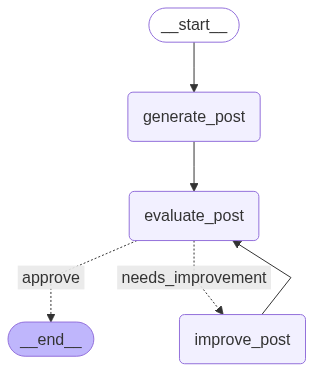

In [150]:
workflow = graph.compile()
workflow

In [151]:
# Initial State
initial_state = PostState(
    topic="Artificial Intelligence in Business",
    max_iteration=3
)

In [152]:
# Run the graph
result = workflow.invoke(initial_state)

In [153]:
result

{'topic': 'Artificial Intelligence in Business',
 'post': "## AI: No Longer a Buzzword, But a Business Imperative 🚀\n\nArtificial Intelligence (AI) is rapidly transforming the business landscape, and frankly, if you're not exploring its potential, you're likely falling behind.\n\nWe're moving beyond the hype and seeing real, tangible results in areas like:\n\n*   **Automation:** Streamlining repetitive tasks, freeing up your team to focus on strategic initiatives. Think automated customer service chatbots or AI-powered invoice processing.\n*   **Personalization:** Delivering tailored experiences to customers based on their preferences and behavior. Imagine personalized product recommendations that actually convert!\n*   **Data Analysis:** Uncovering hidden insights within your data to make smarter, more informed decisions. Forget gut feelings, let the data guide your strategy.\n*   **Improved Efficiency:** Optimizing processes across the board, leading to cost savings and increased pro

## AI: No Longer a Buzzword, But a Business Imperative 🚀

Artificial Intelligence (AI) is rapidly transforming the business landscape, and frankly, if you're not exploring its potential, you're likely falling behind.

We're moving beyond the hype and seeing real, tangible results in areas like:

*   **Automation:** Streamlining repetitive tasks, freeing up your team to focus on strategic initiatives. Think automated customer service chatbots or AI-powered invoice processing.
*   **Personalization:** Delivering tailored experiences to customers based on their preferences and behavior. Imagine personalized product recommendations that actually convert!
*   **Data Analysis:** Uncovering hidden insights within your data to make smarter, more informed decisions. Forget gut feelings, let the data guide your strategy.
*   **Improved Efficiency:** Optimizing processes across the board, leading to cost savings and increased productivity. Supply chain optimization, anyone?

**But where do you even start?**

My advice?

*   **Identify pain points:** Where are you struggling with efficiency, customer experience, or data analysis?
*   **Explore AI solutions:** Research AI-powered tools and platforms that address your specific needs.
*   **Start small:** Implement pilot projects to test the waters and demonstrate ROI.
*   **Invest in training:** Equip your team with the skills they need to leverage AI effectively.

**What are your thoughts on AI in business? What challenges are you facing or what successes have you seen? Let's discuss in the comments! 👇**

#AI #ArtificialIntelligence #BusinessTransformation #Innovation #FutureofWork #Technology #Automation #DataScience #Leadership #BusinessStrategy